# Simulation - default paramaters

#### Maria Silva, February 2024

## Load & imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

In [3]:
from redsim.params import Params
from redsim.sim import run_mc_sim

## Set paramaters

In [4]:
sim_len = int(30 * 60 * 60 * 24 / 12)  # 30 day of ETH blocks
sim_iter = 1000  # MC paths

params = Params()
params.set_default_params()

## Run full MC simulation

In [5]:
sim_df = run_mc_sim(sim_len, sim_iter, params, agg_daily = True)
sim_df.to_csv("../data/sim_default_output.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:43<00:00,  6.12it/s]


## Analyse results

In [6]:
sim_df = pd.read_csv("../data/sim_default_output.csv")
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              30000 non-null  object 
 1   onchain_profit_eth     30000 non-null  float64
 2   onchain_profit_usd     30000 non-null  float64
 3   total_profit_eth       30000 non-null  float64
 4   total_profit_usd       30000 non-null  float64
 5   op_rev_share_cost_eth  30000 non-null  float64
 6   l1_base_fee_gwei       30000 non-null  float64
 7   l1_prio_fee_gwei       30000 non-null  float64
 8   l2_base_fee_gwei       30000 non-null  float64
 9   l2_prio_fee_gwei       30000 non-null  float64
 10  l2_gas                 30000 non-null  float64
 11  da_challenge           30000 non-null  float64
 12  infra_cost_usd         30000 non-null  float64
 13  revenue_eth            30000 non-null  float64
 14  revenue_data_eth       30000 non-null  float64
 15  re

In [16]:
temp_df = (
    sim_df[sim_df["timestamp"]==sim_df["timestamp"].max()] # get last day of sim
    [["onchain_profit_eth", "total_profit_eth", "op_rev_share_cost_eth", "onchain_profit_usd", "total_profit_usd"]]
    .agg(["mean", "std"])
    .T
    .round(2)
)
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,coef_var
onchain_profit_eth,78.21,0.49,0.01
total_profit_eth,62.42,0.41,0.01
op_rev_share_cost_eth,11.73,0.07,0.01
onchain_profit_usd,195537.33,1214.78,0.01
total_profit_usd,156054.76,1032.75,0.01


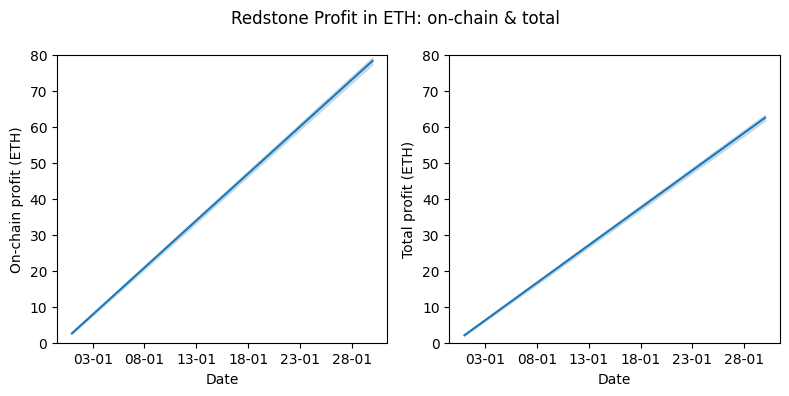

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.lineplot(data=sim_df, x="timestamp", y="onchain_profit_eth", errorbar="pi", ax=axs[0])
axs[0].set_xlabel("Date") 
axs[0].set_ylabel("On-chain profit (ETH)") 
axs[0].set_ylim(0,80)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
sns.lineplot(data=sim_df, x="timestamp", y="total_profit_eth", errorbar="pi", ax=axs[1])
axs[1].set_xlabel("Date") 
axs[1].set_ylabel("Total profit (ETH)") 
axs[1].set_ylim(0,80)
plt.suptitle("Redstone Profit in ETH: on-chain & total")
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.tight_layout()
plt.show()

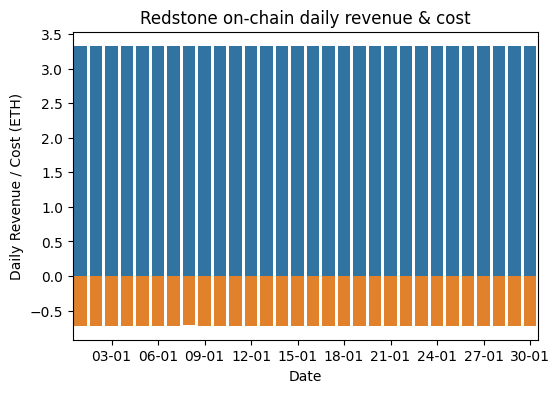

In [9]:
temp_df = sim_df.copy()
temp_df["revenue_eth"] = temp_df["revenue_eth"]
temp_df["onchain_cost_eth"] = -temp_df["onchain_cost_eth"]

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(temp_df, x="timestamp", y="revenue_eth", estimator="mean", errorbar=None)
sns.barplot(temp_df, x="timestamp", y="onchain_cost_eth", estimator="mean", errorbar=None)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel("Date")
plt.ylabel("Daily Revenue / Cost (ETH)")
plt.title("Redstone on-chain daily revenue & cost")
plt.show()

In [18]:
temp_df = (
    sim_df
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .T
    .round(3)
)
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,coef_var
revenue_data_eth,3.258,0.096,0.03
revenue_exec_eth,0.066,0.003,0.05
batcher_gas_cost_eth,0.645,0.015,0.02
proposer_gas_cost_eth,0.059,0.007,0.12
da_gas_cost_eth,0.013,0.019,1.46


1.0864420422670586


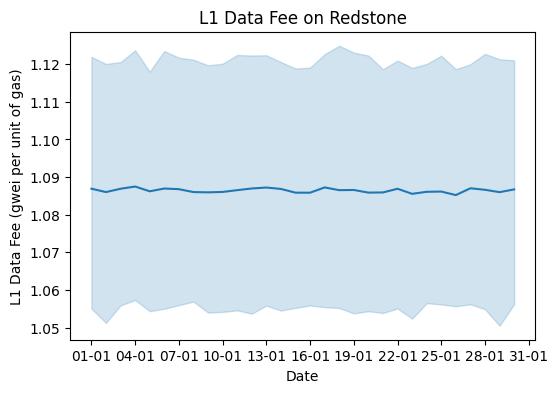

In [11]:
temp_df = sim_df.copy()
temp_df["l1_data_fee_cost"] = temp_df["revenue_data_eth"] / temp_df["l2_gas"]
temp_df["l1_data_fee_cost_gwei"] = temp_df["l1_data_fee_cost"]/0.000000001
print(temp_df["l1_data_fee_cost_gwei"].mean())

fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(temp_df, x="timestamp", y="l1_data_fee_cost_gwei", errorbar="pi")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel("Date")
plt.ylabel("L1 Data Fee (gwei per unit of gas)")
plt.title("L1 Data Fee on Redstone")
plt.show()

0.022051889253885182


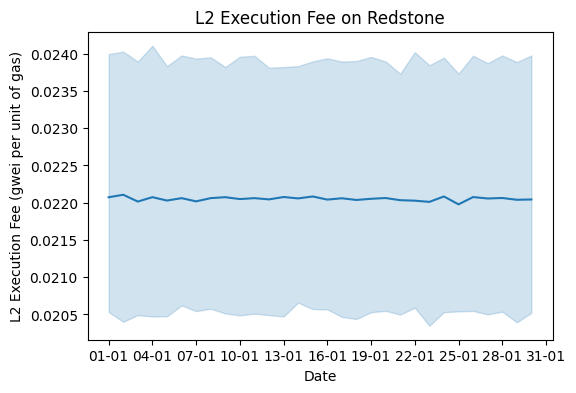

In [12]:
temp_df = sim_df.copy()
temp_df["exec_fee_cost"] = temp_df["revenue_exec_eth"] / temp_df["l2_gas"]
temp_df["exec_fee_cost_gwei"] = temp_df["exec_fee_cost"]/0.000000001
print(temp_df["exec_fee_cost_gwei"].mean())

fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(temp_df, x="timestamp", y="exec_fee_cost_gwei", errorbar="pi")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel("Date")
plt.ylabel("L2 Execution Fee (gwei per unit of gas)")
plt.title("L2 Execution Fee on Redstone")
plt.show()